### データの取得


In [3]:
# 必要なライブラリのインポート
import requests
from bs4 import BeautifulSoup
import time
import random
import pandas as pd

# 指定URL
base_url = "https://www.jalan.net/kankou/spt_10426cd2110076558/kuchikomi/page_{}/?screenId=OUW2202&reviewRefineCompanion=all&reviewRefineMonth=all&resultSort=pd"

# ヘッダー設定
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

# 結果を格納するリスト
visit_dates = []

# 最大ページ数
max_pages = 334

# スクレイピングのメイン処理
for page in range(1, max_pages + 1):
    # ページURLを作成
    url = base_url.format(page)
    print(f"[INFO] Scraping page {page}: {url}")

    try:
        # ページを取得
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()  # HTTPエラーがあれば例外をスロー
        soup = BeautifulSoup(response.content, "html.parser")

        # 各口コミブロックを取得
        review_blocks = soup.find_all("div", class_="item-reviewText")
        if not review_blocks:
            print(f"No reviews found on page {page}. Stopping...")
            break

        # 各ページの口コミを取得（333ページ目は2件、それ以外のページは10件）
        num_reviews_to_get = 10 if page < 333 else 2
        for review in review_blocks[:num_reviews_to_get]:

            # 訪問時期を取得
            details_element = review.find_next_sibling("ul", class_="item-reviewDetail")
            visit_date = "-"
            if details_element:
                detail_items = details_element.find_all("li")
                if len(detail_items) > 0:
                    visit_date = detail_items[0].text.replace("行った時期：", "").strip()

            # データをリストに追加
            visit_dates.append({"VisitDate": visit_date})

            # 各口コミをログとして表示
            print(f" VisitDate: {visit_date}")

        # リクエストごとにランダムな待機時間を設定
        wait_time = random.uniform(3, 5)
        print(f"Waiting for {wait_time:.2f} seconds before the next request...")
        time.sleep(wait_time)

    except requests.exceptions.RequestException as e:
        # エラー発生時のログ
        print(f"Failed to scrape page {page}: {e}")
        continue

# 結果の確認（取得した訪問時期の表示、一部のみ）
print(f"Scraping completed. Total visit dates scraped: {len(visit_dates)}")
for visit_date in visit_dates[:10]:  # 最初の10件を表示
    print(f"[RESULT] {visit_date}")

# 結果をCSVファイルに保存
df = pd.DataFrame(visit_dates)
df.to_csv('visit_dates.csv', index=False, encoding='utf-8-sig')
print("[INFO] Visit dates have been saved to visit_dates.csv")

[INFO] Scraping page 1: https://www.jalan.net/kankou/spt_10426cd2110076558/kuchikomi/page_1/?screenId=OUW2202&reviewRefineCompanion=all&reviewRefineMonth=all&resultSort=pd
 VisitDate: 2024年11月
 VisitDate: 2024年11月
 VisitDate: 2024年6月
 VisitDate: 2024年11月13日
 VisitDate: 2024年10月18日
 VisitDate: 2024年10月
 VisitDate: 2024年11月
 VisitDate: 2024年11月
 VisitDate: 2024年11月7日
 VisitDate: 2024年10月13日
Waiting for 3.58 seconds before the next request...
[INFO] Scraping page 2: https://www.jalan.net/kankou/spt_10426cd2110076558/kuchikomi/page_2/?screenId=OUW2202&reviewRefineCompanion=all&reviewRefineMonth=all&resultSort=pd
 VisitDate: 2024年10月20日
 VisitDate: 2024年10月17日
 VisitDate: 2024年10月
 VisitDate: 2024年10月
 VisitDate: 2024年9月22日
 VisitDate: 2024年8月
 VisitDate: 2024年8月
 VisitDate: 2024年8月21日
 VisitDate: 2024年8月9日
 VisitDate: 2024年8月3日
Waiting for 3.51 seconds before the next request...
[INFO] Scraping page 3: https://www.jalan.net/kankou/spt_10426cd2110076558/kuchikomi/page_3/?screenId=OUW2202&re

###  SQLiteデータベースを作成し、クエリを用いてデータ取得

In [36]:
# ライブラリのインポート
import sqlite3
import matplotlib.pyplot as plt
import japanize_matplotlib

# データの読み込み
data_path = "visit_dates.csv"  # CSVファイルパス
df = pd.read_csv(data_path)

# SQLiteデータベースを作成
conn = sqlite3.connect("visit_data.db")
df.to_sql("visits", conn, if_exists="replace", index=False)


3322

In [37]:
# SQLiteからクエリを用いてデータ取得
query = "SELECT * FROM visits WHERE VisitDate LIKE '%月%'"
data = pd.read_sql(query, conn)

print("取得したデータのサンプル:")
print(data.head())

取得したデータのサンプル:
     VisitDate
0     2024年11月
1     2024年11月
2      2024年6月
3  2024年11月13日
4  2024年10月18日


### データの可視化

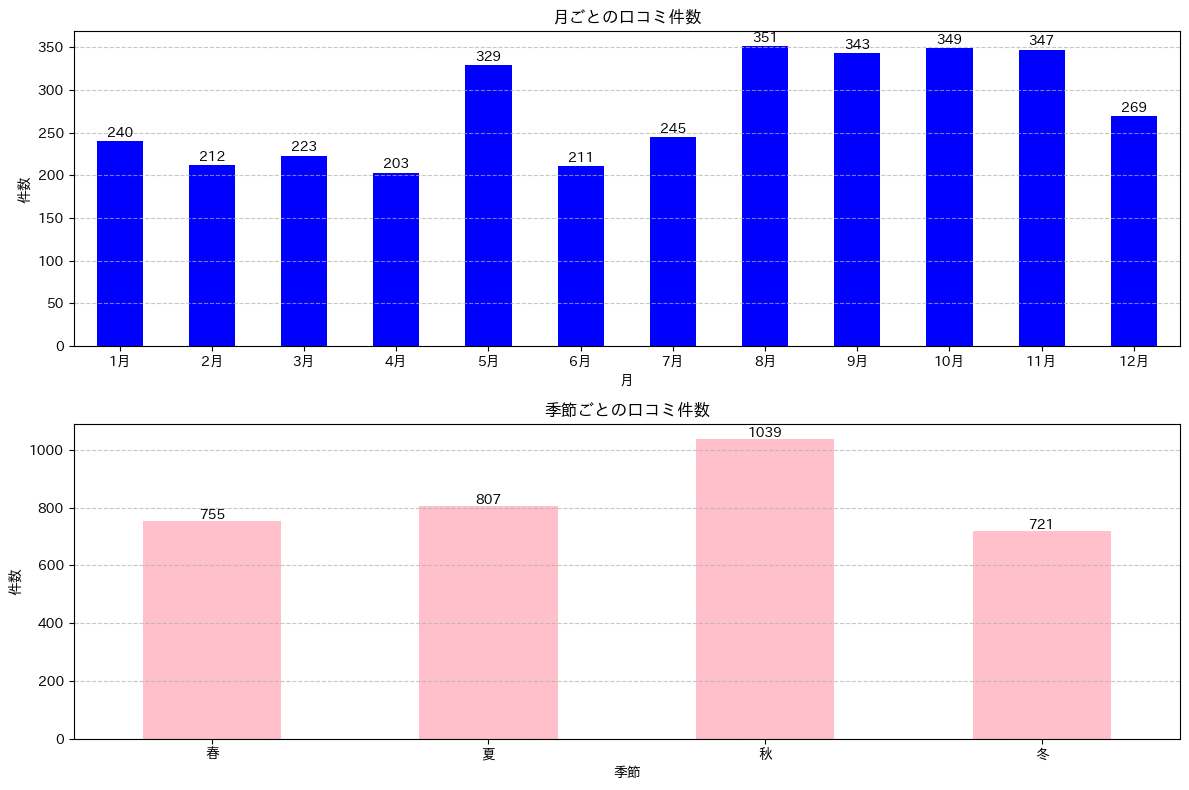

In [46]:
# CSVファイルからデータを読み込む
data_path = "visit_dates.csv"
df = pd.read_csv(data_path)

# 月の抽出と集計
df['Month'] = df['VisitDate'].str.extract(r'(\d+)月').astype(float) 
monthly_counts = df['Month'].value_counts().sort_index()

# 季節ごとに分類
seasons = {
    1: "冬", 2: "冬", 3: "春",
    4: "春", 5: "春", 6: "夏",
    7: "夏", 8: "夏", 9: "秋",
    10: "秋", 11: "秋", 12: "冬"
}
df['Season'] = df['Month'].map(seasons)
seasonal_counts = df['Season'].value_counts().reindex(["春", "夏", "秋", "冬"])

# グラフのプロット
plt.figure(figsize=(12, 8))

# 月ごとのグラフ
plt.subplot(2, 1, 1)
monthly_counts.index = [f"{int(month)}月" for month in monthly_counts.index] 
bars = monthly_counts.plot(kind='bar', color='blue')
plt.title("月ごとの口コミ件数")
plt.xlabel("月")
plt.ylabel("件数")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 件数を棒グラフ上に表示
for idx, value in enumerate(monthly_counts):
    plt.text(idx, value + 5, str(value), ha='center', fontsize=10)

# 季節ごとのグラフ
plt.subplot(2, 1, 2)
bars = seasonal_counts.plot(kind='bar', color='pink')
plt.title("季節ごとの口コミ件数")
plt.xlabel("季節")
plt.ylabel("件数")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 件数を棒グラフ上に表示
for idx, value in enumerate(seasonal_counts):
    plt.text(idx, value + 5, str(value), ha='center', fontsize=10)

# グラフを表示
plt.tight_layout()
plt.show()

### URLを入力したらそのページをスクレイピングする

In [45]:
class Scraper:
    def __init__(self, base_url, max_pages, file_name):
        self.base_url = base_url
        self.max_pages = max_pages
        self.file_name = file_name
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
        self.visit_dates = []

    def scrape(self):
        for page in range(1, self.max_pages + 1):
            url = self.base_url.format(page)
            print(f"[INFO] Scraping page {page}: {url}")
            try:
                response = requests.get(url, headers=self.headers, timeout=10)
                response.raise_for_status()
                soup = BeautifulSoup(response.content, "html.parser")

                # 各口コミブロックを取得
                review_blocks = soup.find_all("div", class_="item-reviewText")
                if not review_blocks:
                    print(f"No reviews found on page {page}. Stopping...")
                    break

                for review in review_blocks:
                    # 訪問時期を取得
                    details_element = review.find_next_sibling("ul", class_="item-reviewDetail")
                    visit_date = "-"
                    if details_element:
                        detail_items = details_element.find_all("li")
                        if len(detail_items) > 0:
                            visit_date = detail_items[0].text.replace("行った時期：", "").strip()

                    # データをリストに追加
                    self.visit_dates.append({"VisitDate": visit_date})

                    print(f" VisitDate: {visit_date}")

                # ランダムな待機時間を設定
                wait_time = random.uniform(3, 5)
                print(f"Waiting for {wait_time:.2f} seconds before the next request...")
                time.sleep(wait_time)

            except requests.exceptions.RequestException as e:
                print(f"Failed to scrape page {page}: {e}")
                continue

        print(f"Scraping completed. Total visit dates scraped: {len(self.visit_dates)}")
        self.save_to_csv()

    def save_to_csv(self):
        df = pd.DataFrame(self.visit_dates)
        df.to_csv(self.file_name, index=False, encoding="utf-8-sig")
        print(f"[INFO] Visit dates have been saved to {self.file_name}")


if __name__ == "__main__":
    # ユーザー入力
    base_url = input("Enter the base URL (use '{}' as a placeholder for page numbers): ")
    max_pages = int(input("Enter the number of pages to scrape: "))
    file_name = input("Enter the file name to save results (e.g., 'results.csv'): ")

    scraper = Scraper(base_url, max_pages, file_name)
    scraper.scrape()

[INFO] Scraping page 1: https://www.jalan.net/kankou/spt_10426cd2110076558/kuchikomi/page_1/?screenId=OUW2202&reviewRefineCompanion=all&reviewRefineMonth=all&resultSort=pd
 VisitDate: 2024年11月
 VisitDate: 2024年11月
 VisitDate: 2024年6月
 VisitDate: 2024年11月13日
 VisitDate: 2024年10月18日
 VisitDate: 2024年10月
 VisitDate: 2024年11月
 VisitDate: 2024年11月
 VisitDate: 2024年11月7日
 VisitDate: 2024年10月13日
 VisitDate: -
 VisitDate: -
 VisitDate: -
 VisitDate: -
Waiting for 3.29 seconds before the next request...
[INFO] Scraping page 2: https://www.jalan.net/kankou/spt_10426cd2110076558/kuchikomi/page_2/?screenId=OUW2202&reviewRefineCompanion=all&reviewRefineMonth=all&resultSort=pd
 VisitDate: 2024年10月20日
 VisitDate: 2024年10月17日
 VisitDate: 2024年10月
 VisitDate: 2024年10月
 VisitDate: 2024年9月22日
 VisitDate: 2024年8月
 VisitDate: 2024年8月
 VisitDate: 2024年8月21日
 VisitDate: 2024年8月9日
 VisitDate: 2024年8月3日
 VisitDate: -
 VisitDate: -
 VisitDate: -
 VisitDate: -
Waiting for 3.76 seconds before the next request...
